In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.io import loadmat

In [2]:
mat_f = r'./data/LST_template.mat'
mat_data = loadmat(mat_f)

# Linear Stability Theory

In [3]:
# Input parameters 
N       = 384 # number of Chebyshev polynomials

R  = 180         # Reynolds number
kx = 1           # streamwise wavenumber
kz = 0           # spanwise wavenumber
Ri = 0.0        # Richardson number
Pr = 0.71        # Prantl number
Ra = 8*R*R/Pr*Ri # Rayleigh number
print('Rayleigh number is '+ str(Ra))

bf = 2   # set = 1 for Couette, 2 for Poiseuille, 3 for quiescent

Rayleigh number is 0.0


This LST code use Chebyshev polynomials in z direction. $D_0$ is the first eigen-mode and $D_1$ is the second eigen-mode.

$$
\mathbf{D_0^i}(jdy) \equiv D_0(i, j) =\cos{(i y)}=  \cos{(i \times j\times \mathrm{d}y)}, \quad \forall i, j \in 0, 1, 2 \dots N-1
$$

<span style='color:red'> what i and j represent?</span>

$$
D_1(i, j) = \begin{bmatrix}
 \mathbf{0} & 
 \mathbf{D}_0(i, 0) &
 4*\mathbf{D}_0(i, 1) &
 2*j*\mathbf{D}_0(i, j-1) + j*\mathbf{D}_1(i, j-2)/(j-2)
\end{bmatrix},
\quad \forall i, j\in 0, 1, 2 \dots N-1
$$

In [4]:
def dmat(N):
    num = N-1
    D0 = np.cos(np.arange(N)[np.newaxis, :]  * np.pi * np.arange(N)[:, np.newaxis] / num )
    
    # create higher derivative matrices
    D1 = np.concatenate((np.zeros(shape=(N, 1)), D0[:, 0][:, np.newaxis], 4*D0[:, 1][:, np.newaxis]), axis=1)
    D2 = np.concatenate((np.zeros(shape=(N, 2)), 4*D0[:, 1][:, np.newaxis]), axis=1)
    D3 = np.zeros(shape=(N, 3))
    D4 = np.zeros(shape=(N, 3))



    for j in range(3, N):
        D1= np.concatenate((D1, 2*j*D0[:, j-1][:, np.newaxis]+j*D1[:, j-2][:, np.newaxis]/(j-2)), axis=1)
        D2= np.concatenate((D2, 2*j*D1[:, j-1][:, np.newaxis]+j*D2[:, j-2][:, np.newaxis]/(j-2)), axis=1)
        D3= np.concatenate((D3, 2*j*D2[:, j-1][:, np.newaxis]+j*D3[:, j-2][:, np.newaxis]/(j-2)), axis=1)
        D4= np.concatenate((D4, 2*j*D3[:, j-1][:, np.newaxis]+j*D4[:, j-2][:, np.newaxis]/(j-2)), axis=1)
        
    return D0, D1, D2, D3, D4

In [5]:
# Set up grid and differentiation matrices
y_phys                = np.cos(np.linspace(0, np.pi, N))[:, np.newaxis]   # Generate Chebyshev grid for base flow solver
D0,D1,D2,D3,D4 = dmat(N)   # Chebyshev polynomials and derivatives at the Gauss points

In [6]:
def bounded_base(y_phys,N,bf):
    if bf == 1: # Couette flow
   
        U   = y_phys
        Up  = np.ones(shape=(N, 1))
        Upp = np.zeros(shape=(N, 1))
        T   = y_phys
        Tp  = np.zeros(shape=(N, 1))
        
    elif bf == 2 : # Poiseuille flow
        
        U   = (1 - y_phys**2)
        Up  = -2*y_phys
        Upp = -2*np.ones(shape=(N, 1))
        T   = np.zeros(shape=(N, 1))
        Tp  = np.zeros(shape=(N, 1))
        
    elif bf == 3: # quiescent flow
        
        U   = np.zeros(shape=(N, 1))
        Up  = np.zeros(shape=(N, 1))
        Upp = np.zeros(shape=(N, 1))
        T   = y_phys
        Tp  = np.ones(shape=(N, 1))
    else:
        print('Need to select bf = 1 or 2')
        
        
    return U,Up,Upp,T,Tp

In [7]:
# Find the base flow
[U,Up,Upp,T,Tp] = bounded_base(y_phys,N,bf)

### Operator A

**LSQ**

$$
\begin{equation}
\text{LSQ} = -\mathrm{i}k_x \mathbf{U} * \mathbf{D_0} + \frac{1}{\text{Re}} * (\mathbf{D_2} - (k_x^2 + k_z^2) * \mathbf{D_0})
\end{equation}
$$


In [8]:
def Operator(kx,kz,R,Pr,Ri,U,Up,Upp,Tp,D0,D1,D2,D4):
    # Useful variables --------------------------------------------------------
    k2 = kx**2 + kz**2       # wavenumber^2
    N  = U.shape[0]
    M  =  np.ones(shape=(1, N)) # matrix for mean flow variables 
    er = -200*1j           # for spurious eigenvalues from BCs

    LSQ = -1j*kx*(U@M)*D0 + (1/R)*(D2-k2*D0)
    LOS = -1j*kx*(U@M)*(D2-k2*D0) + 1j*kx*(Upp@M)*D0 + (1/R)*(D4-(2*k2*D2)+((k2**2)*D0))
    A32 = -1j*kx*(U@M)*D0 + (1/R/Pr)*(D2-k2*D0)
    
    A = np.block([[LOS, np.zeros((N, N)), -Ri*k2*D0],[-1j*kz*(Up@M*D0) , LSQ, np.zeros((N, N))],[-(Tp@M*D0), np.zeros((N, N)), A32]])

    B = np.block([[D2-k2*D0, np.zeros((N, N)), np.zeros((N, N))], [np.zeros((N, N)), D0, np.zeros((N, N))], [np.zeros((N, N)),  np.zeros((N, N)), D0]])

    B[0, 0:N] = D0[0, :]
    B[1, 0:N, ] = D1[0, :] # v, Dv at y = top
    B[N-2, 0:N] = D1[N-1, :]
    B[N-1, 0:N] = D0[N-1, :] # v, Dv at y = bot

    # apply boundary condtions to top and bottom 2 rows (i.e. v = Dv = 0)
    A[0, 0:N] = er*D0[0, :]       # vanishing in the free stream
    A[1, 0:N] = er*D1[0, :]       # vanishing in the free stream
    A[N-2, 0:N] = er*D1[N-1, :]   # gradient vanishing at wall (no slip)
    A[N-1, 0:N] = er*D0[N-1, :]   # no penetration at wall

    # clear the rows to apply Squire boundary conditions ----------------------
    A[N, :] = 0
    A[2*N-1, :] = 0

    # apply Squire boundary conditions (eta = 0 at y=top,bot)
    A[N, N:2*N, ] = er*D0[0, :]
    A[2*N-1, N:2*N, ] = er*D0[N-1, :]

    # apply temperature boundary conditions
    A[2*N, :] = 0
    A[3*N-1, :] = 0

    A[2*N, 2*N:3*N] = er*D0[0, :]
    A[3*N-1, 2*N:3*N] = er*D0[N-1, :]
    return A, B

In [9]:
# Find eigenvalues of stability operators
A, B = Operator(kx,kz,R,Pr,Ri,U,Up,Upp,Tp,D0,D1,D2,D4)

In [10]:
print(B[:10, 5])

[  1.          25.         198.89034754 198.75333266 198.56160646
 198.31526351 198.01442532 197.65924028 197.24988361 196.78655723]


In [11]:
# find eigenvalues
# omega, q = linalg.eig(A, B)
omega, q = np.linalg.eig(np.linalg.inv(B)@A)


omega = 1j*omega   # eigenvalues omega in vector form

# remove bad eigenvalues
sp = np.logical_and(abs(omega)>1e-10, abs(omega)<50)

omega = omega[sp]
q = q[:, sp]

In [12]:
test = (mat_data['A']-A)
print(test[test==test.max()])
ind = np.unravel_index(test.argmax(), test.shape)
print(ind)
print(A.shape)
print(A[ind])
print(mat_data['A'][ind])
print(A[ind] - mat_data['A'][ind])

[2.25929628e+10-0.41116616j]
(381, 382)
(1152, 1152)
(1033556508921767.1+146284.7244754538j)
(1033579101884599.6+146284.3133092962j)
(-22592962832.5+0.41116615760256536j)


In [13]:
# find eigenvalues
# omega_mat, q_mat = linalg.eig( mat_data['A'], mat_data['B'])
omega_mat, q_mat = np.linalg.eig(np.linalg.inv(mat_data['B']) @ mat_data['A'])


omega_mat = 1j*omega_mat   # eigenvalues omega in vector form


# remove bad eigenvalues
sp = np.logical_and(abs(omega_mat)>1e-10, abs(omega_mat)<50)

omega_mat = omega_mat[sp]
q_mat = q_mat[:, sp]

In [14]:
def vel_field(kx,kz,D0,D1,q,N):

    k2 = kx**2 + kz**2

    # note q is the truncated matrix of eigenfunctions (the first K eigenfunctions)

    # extract known eigenfunctions from q ------------------------------------#
    v   = D0 @ q[:N,:]
    Dv  = D1 @ q[:N,:] # vertical velocity and its gradient
    eta = D0 @ q[N:2*N,:] # wall normal vorticity
    #-------------------------------------------------------------------------#

    # find full velocity field (using continuity and definition of normal
    # vorticity) -------------------------------------------------------------#
    u = np.zeros(v.shape)
    w = np.zeros(v.shape)

    for i in range(u.shape[1]):

        u[:,i] = (1j/k2)*(kx*Dv[:,i] - kz*eta[:,i])
        w[:,i] = (1j/k2)*(kz*Dv[:,i] + kx*eta[:,i])

    return u,v,w,eta

In [15]:
[u,v,w,eta] = vel_field(kx,kz,D0,D1,q,N)
Temperature = D0 @ q[2*N:3*N,:]

/var/folders/k8/qt94yf_n5xgbshl47l1m1drr0000gn/T/ipykernel_93238/1962380066.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  u[:,i] = (1j/k2)*(kx*Dv[:,i] - kz*eta[:,i])
/var/folders/k8/qt94yf_n5xgbshl47l1m1drr0000gn/T/ipykernel_93238/1962380066.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  w[:,i] = (1j/k2)*(kz*Dv[:,i] + kx*eta[:,i])


In [16]:
# remove bad eigenvalues
sp_mat = np.logical_and(abs(mat_data['omega'])>1e-10, abs(mat_data['omega'])<50)

mat_data['omega'] = mat_data['omega'][sp_mat]
mat_data['q'] = mat_data['q'][:, np.squeeze(sp_mat)]

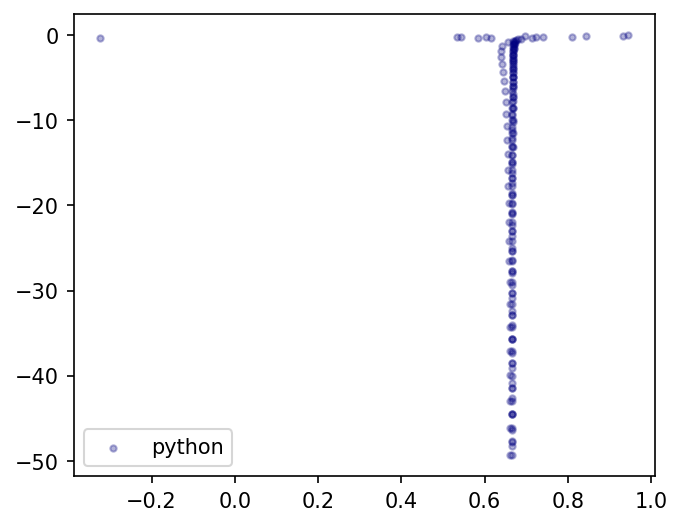

In [18]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=150)
ax.scatter(np.real(omega), np.imag(omega), marker='.', color='navy', alpha=0.3, label='python')
# ax.scatter(np.real(mat_data['omega']), np.imag(mat_data['omega']), marker='x', color='red', alpha=0.3, label='matlab')
# ax.scatter(np.real(omega_mat), np.imag(omega_mat), marker='.', color='green', alpha=0.3, label='pylab')

ax.legend()
# ax.set_xlim(0, 1)
# ax.set_ylim(-10, 5)